# BUĞDAY BAŞAKLARININ TESPİT EDİLMESİ: GÖRÜNTÜLERİN ANALİZ EDİLEREK BAŞAK YOĞUNLUĞU, SAĞLIK VE OLGUNLUK BİLGİLERİNİN ELDE EDİLMESİ  
 
 -----

### ÖZET


Bu çalışmamızda buğday başaklarının takibini yapılarak sağlıklı gelişim süreci sağlanması için optik görüntülerden başak yoğunluğu, olgunluk ve temel sağlık bilgilerinin çıkarımı hedeflenmektedir. Bu amaçla görüntü işleme ve makine öğrenimi metotları kullanılarak buğday fotoğraflarından temel sağlık verileri elde edilmesi amaçlanmaktadır. Bu veriler buğday üreticisinin üretim sürecindeki kayıplara ilişkin çözümlerin oluşturulması ve kaliteli ürün elde edilmesi açısından fayda sağlayacaktır.

### ABSTRACT


In this study, it is aimed to extract spike density, maturity and basic health information from optical images in order to provide a healthy development process by monitoring wheat ears. Fort his purpose it is aimed to obtain basic health data from wheat optic images by using image processing and machine learning methods. These data will be beneficial in creating solutions for the losses in the production process of the wheat producer and obtaining quality products.


****

In [1]:
# KÜTÜPHANELERİN YÜKLENMESİ / İMPORT LİBRARY

import os
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2



def printime(title):
    print("{0}: {1}".format(title, datetime.datetime.now()))

In [2]:
# Model Sonuçlarının Yüklenmesi / Load Model Results
latesub = pd.read_csv("../input/wheat-latesub/submission.csv")
print("Trained model summary output shape:",latesub.shape)
imageid_count = latesub['image_id'].value_counts()
print("Example dataset image count: ",len(imageid_count))
print(imageid_count)
latesub.head()

Trained model summary output shape: (282, 2)
Example dataset image count:  10
348a992bb    38
53f253011    33
796707dd7    32
f5a1f0358    30
2fd875eaa    29
cc3532ff6    28
cb8d261a3    27
51b3e36ab    25
aac893a91    22
51f1be19e    18
Name: image_id, dtype: int64


,image_id,PredictionString
0,796707dd7,0.6988 658 75 80 75
1,796707dd7,0.7250 765 875 101 94
2,796707dd7,0.7013 949 378 106 87
3,796707dd7,0.6868 550 836 88 100
4,796707dd7,0.6952 523 317 104 96


In [3]:
latesub["PredictionString"] = latesub["PredictionString"].str.split(' ')
latesub.head()

,image_id,PredictionString
0,796707dd7,"[0.6988, 658, 75, 80, 75]"
1,796707dd7,"[0.7250, 765, 875, 101, 94]"
2,796707dd7,"[0.7013, 949, 378, 106, 87]"
3,796707dd7,"[0.6868, 550, 836, 88, 100]"
4,796707dd7,"[0.6952, 523, 317, 104, 96]"


In [4]:
# Yüklenen Sonuçların Düzenlenmesi / Editing Uploaded Results
def preparingdf(df):
    iou = []
    tx = []
    ty = []
    tw = []
    th = []
    for i in df.iterrows():
        idx0 = i[1][1][0]
        idx1 = i[1][1][1]
        idx2 = i[1][1][2]
        idx3 = i[1][1][3]
        idx4 = i[1][1][4]
        iou.append(idx0)
        tx.append(idx1)
        ty.append(idx2)
        tw.append(idx3)
        th.append(idx4)
        
    df[['iou']] = iou
    df[['tx']] = tx
    df[['ty']] = ty
    df[['tw']] = tw
    df[['th']] = th
    

    return df


data = preparingdf(latesub)
data.iou = data.iou.astype(float)
data.tx = data.tx.astype(float)
data.ty = data.ty.astype(float)
data.tw = data.tw.astype(float)
data.th = data.th.astype(float)
data.head()

,image_id,PredictionString,iou,tx,ty,tw,th
0,796707dd7,"[0.6988, 658, 75, 80, 75]",0.6988,658.0,75.0,80.0,75.0
1,796707dd7,"[0.7250, 765, 875, 101, 94]",0.7250,765.0,875.0,101.0,94.0
2,796707dd7,"[0.7013, 949, 378, 106, 87]",0.7013,949.0,378.0,106.0,87.0
3,796707dd7,"[0.6868, 550, 836, 88, 100]",0.6868,550.0,836.0,88.0,100.0
4,796707dd7,"[0.6952, 523, 317, 104, 96]",0.6952,523.0,317.0,104.0,96.0


In [5]:
data.groupby(['image_id'])['iou'].max()

image_id
2fd875eaa    0.8152
348a992bb    0.7839
51b3e36ab    0.7848
51f1be19e    0.6751
53f253011    0.7648
796707dd7    0.7250
aac893a91    0.7072
cb8d261a3    0.7902
cc3532ff6    0.7755
f5a1f0358    0.7507
Name: iou, dtype: float64

In [6]:
df = data.groupby(['image_id']).mean()

df[['count']] = imageid_count
df[['iou_min']] = data.groupby(['image_id'])['iou'].min()
df[['iou_max']] = data.groupby(['image_id'])['iou'].max()
df[['tw_min']] = data.groupby(['image_id'])['tw'].min()
df[['tw_max']] = data.groupby(['image_id'])['tw'].max()
df[['th_min']] = data.groupby(['image_id'])['th'].min()
df[['th_max']] = data.groupby(['image_id'])['th'].max()

df['FX'] = (1024*1024)//(df.tw_max*df.th_max)
df['FY'] = df['count']/df.FX

df.head()

,iou,tx,ty,tw,th,count,iou_min,iou_max,tw_min,tw_max,th_min,th_max,FX,FY
image_id,,,,,,,,,,,,,,
2fd875eaa,0.693383,488.103448,577.137931,82.689655,74.724138,29,0.5149,0.8152,26.0,136.0,22.0,131.0,58.0,0.500000
348a992bb,0.661097,484.763158,565.710526,83.000000,75.526316,38,0.5523,0.7839,43.0,138.0,34.0,101.0,75.0,0.506667
51b3e36ab,0.666700,478.040000,538.840000,138.960000,128.240000,25,0.5413,0.7848,67.0,329.0,71.0,288.0,11.0,2.272727
51f1be19e,0.615394,556.444444,550.833333,109.500000,115.833333,18,0.5157,0.6751,51.0,197.0,66.0,219.0,24.0,0.750000
53f253011,0.673512,472.636364,543.787879,106.333333,111.757576,33,0.5251,0.7648,30.0,198.0,26.0,219.0,24.0,1.375000


In [7]:
df.columns

Index(['iou', 'tx', 'ty', 'tw', 'th', 'count', 'iou_min', 'iou_max', 'tw_min',
       'tw_max', 'th_min', 'th_max', 'FX', 'FY'],
      dtype='object')

In [8]:
df.shape

(10, 14)

In [9]:
columns = ['iou', 'tx', 'ty', 'tw', 'th']
df.drop(columns, inplace=True, axis=1)
df.head()

,count,iou_min,iou_max,tw_min,tw_max,th_min,th_max,FX,FY
image_id,,,,,,,,,
2fd875eaa,29,0.5149,0.8152,26.0,136.0,22.0,131.0,58.0,0.500000
348a992bb,38,0.5523,0.7839,43.0,138.0,34.0,101.0,75.0,0.506667
51b3e36ab,25,0.5413,0.7848,67.0,329.0,71.0,288.0,11.0,2.272727
51f1be19e,18,0.5157,0.6751,51.0,197.0,66.0,219.0,24.0,0.750000
53f253011,33,0.5251,0.7648,30.0,198.0,26.0,219.0,24.0,1.375000


In [10]:
test_dir = "../input/global-wheat-detection/test/"
testfile = os.listdir(test_dir)

In [11]:
len(testfile)

10

In [12]:
# Test görüntülerin yüklenmesi / Uploading test images
img = cv2.imread(test_dir+testfile[2])
img.shape

(1024, 1024, 3)

In [13]:
# Görüntün BGR formatından LAB formatına dönüştürülmesi / Converting the image from BGR format to LAB format
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

l = lab[:,:,0]
a = lab[:,:,1]
b = lab[:,:,2]

In [14]:
def summary(test_dir):
    testfiles = os.listdir(test_dir)
    for i in len(testfiles):
        img = cv2.imread(test_dir+testfile[i])
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l = lab[:,:,0]
        a = lab[:,:,1]
        b = lab[:,:,2]
        clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(16,16))
        clahe_img = clahe.apply(l)
        img_result = cv2.merge((clahe_img,a,b))
        imgCLAHE = cv2.cvtColor(img_result, cv2.COLOR_LAB2RGB)

(array([    0.,    35.,   299.,  3529.,  5073.,  5818.,  5717.,  8808.,
         3248., 10673., 15014.,  7374., 15551.,  8596., 21225., 12857.,
        18754., 11585., 20618.,  9394., 17840., 18301., 11646., 15085.,
        10102., 16390., 10188., 18019., 11191., 16814., 16615., 11334.,
        17477., 11596., 16204., 10323., 15523., 10919., 16427., 10238.,
        15837., 14456., 10377., 14860., 10527., 17480., 11433., 15538.,
        10745., 15675., 16835., 10806., 15987.,  9601., 15045., 10310.,
        14760., 10351., 14345., 10117., 13328., 13103.,  8204., 12229.,
         8173., 12812.,  8353., 12600.,  8244., 13415., 13471.,  8656.,
        13377.,  8752., 12768.,  7662., 11983.,  7586., 11529.,  7687.,
        11327., 10797.,  6923., 10086.,  6596.,  9627.,  5737.,  8192.,
         5025.,  6759.,  5828.,  3346.,  4256.,  2239.,  2625.,  1182.,
         1385.,   612.,   516.,   101.]),
 array([  0.  ,   2.55,   5.1 ,   7.65,  10.2 ,  12.75,  15.3 ,  17.85,
         20.4 ,  22.95

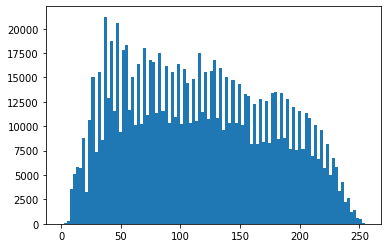

In [15]:
# LAB formatındaki görüntünün histogram çıktısı / Histogram output of image in LAB format
plt.hist(l.flat, bins=100, range=(0,255))

(array([  444.,  3785.,  4196.,  7920.,  5945.,  9677.,  6791., 10571.,
         7133., 11228., 11603.,  7952., 12381.,  8407., 13136.,  9106.,
        13731.,  9341., 14181.,  9426., 14461., 14410.,  9810., 14637.,
         9620., 14485.,  9479., 14147.,  9388., 13907., 13674.,  9038.,
        13676.,  9135., 13868.,  9531., 14312.,  9504., 14136.,  9489.,
        14092., 13831.,  9109., 13777.,  9283., 13876.,  9490., 14511.,
         9709., 14824., 14979.,  9848., 14917.,  9930., 15183., 10395.,
        15268., 10191., 15104., 10059., 14768., 14654.,  9758., 14570.,
         9789., 14452.,  9706., 14656.,  9893., 14823., 14709.,  9688.,
        14489.,  9401., 13843.,  9021., 13036.,  8466., 12338.,  8320.,
        12285., 11588.,  7547., 10869.,  7124., 10048.,  6469.,  9232.,
         5825.,  8422.,  8226.,  5108.,  7399.,  4604.,  6695.,  4122.,
         5909.,  3778.,  4745.,  2164.]),
 array([  0.  ,   2.55,   5.1 ,   7.65,  10.2 ,  12.75,  15.3 ,  17.85,
         20.4 ,  22.95

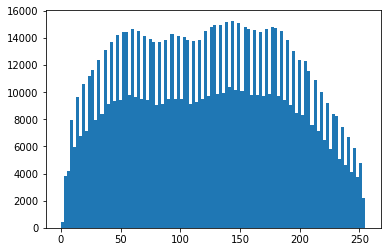

In [16]:
# Yukarıdaki LAB formatına CHALE yöntemi uygulanması / Applying the CHALE method to the above LAB format
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(16,16))
clahe_img = clahe.apply(l)

plt.hist(clahe_img.flat, bins=100, range=(0,255))

In [17]:
img_result = cv2.merge((clahe_img,a,b))
imgNORM = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB) # CHALE uygulanmamış / not apply CHALE
imgCLAHE = cv2.cvtColor(img_result, cv2.COLOR_LAB2RGB) # CHALE uygulanmış / apply CHALE

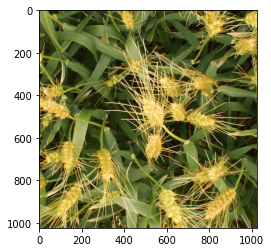

In [18]:
# Görüntünün ilk hali... / First State
plt.imshow(imgNORM)

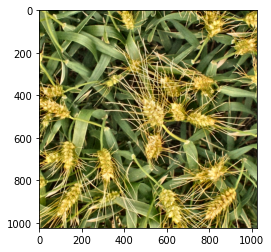

In [19]:
# CHALE uygulandıktan sonra... / Last State 
plt.imshow(imgCLAHE)

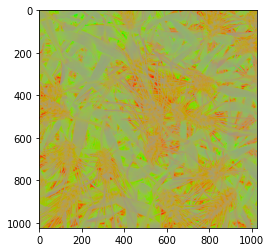

In [20]:
im = imgCLAHE
im = (im/(im.max()-im.min()))*255
im_r = im[:,:,0]
im_g = im[:,:,1]
im_b = im[:,:,2]
im_ = ((im_r**2)+(im_g**2)+(im_b**2))**(1/2)
r=im_r/im_
g=im_g/im_
b=im_b/im_
img__ = cv2.merge((r,g,b))
plt.imshow(img__) #NORMALİZASYON UYGULANMIŞ GÖRÜNTÜ

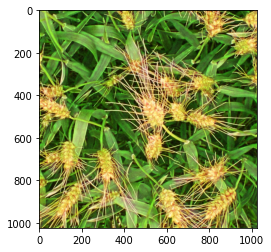

In [21]:
# Sadece yeşil kanala CHALE uygulanması durumunda / AND apply CLAHE ONLY GREEN CHANNEL
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(64,64))
#clahe_img0 = clahe.apply(img[:,:,0])
clahe_img1 = clahe.apply(img[:,:,1]) # Green Channel
#clahe_img2 = clahe.apply(img[:,:,2])

img_result = cv2.merge((img[:,:,0],clahe_img1,img[:,:,2]))
img_result = cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)
plt.imshow(img_result)

In [22]:
imgCLAHE.shape # Görüntü çözünürlük değeri

(1024, 1024, 3)

In [23]:
def inorm(im): #Normalize Fonksiyonu
    im = (im/(im.max()-im.min()))*255
    im_r = im[:,:,0]
    im_g = im[:,:,1]
    im_b = im[:,:,2]
    im_ = ((im_r**2)+(im_g**2)+(im_b**2))**(1/3)
    r=im_r/im_
    g=im_g/im_
    b=im_b/im_
    img__ = cv2.merge((r,g,b))
    return img__

def rgb_density(img): #Renk Yoğunluk Fonksiyonu
    img = inorm(img)
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    s = img.sum()
    d1 = r.sum()/s
    d2 = g.sum()/s
    d3 = b.sum()/s
    return [d1,d2,d3]
    
rgb_density(imgNORM)
    

[0.4080162173459889, 0.4172407059395623, 0.17474307671444878]

In [24]:
rgb_density(imgCLAHE) #CHALE uygulanmış görüntüdeki renk yogunluk değeri sırasıyla (R,G,B)

[0.40590539078110377, 0.41091162220395067, 0.18318298701494512]

In [25]:
rgb_density(img_result) #Yanlız yeşil kanala CHALE uygulanmış görüntüdeki renk yogunluk değeri sırasıyla (R,G,B)

[0.3785105708843702, 0.4601218698674805, 0.16136755924814847]

In [26]:
rgb_density(img__)

[0.40953360365112035, 0.4184585432102319, 0.17200785313864722]

In [27]:
def summary(df, test_dir):
    testfiles = os.listdir(test_dir)
    df[['y_r']] = 0
    df[['y_g']] = 0
    df[['y_b']] = 0

    for i in range(len(testfiles)):
        img = cv2.imread(test_dir+testfile[i])
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l = lab[:,:,0]
        a = lab[:,:,1]
        b = lab[:,:,2]
        clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(16,16))
        clahe_img = clahe.apply(l)
        img_result = cv2.merge((clahe_img,a,b))
        imgCLAHE = cv2.cvtColor(img_result, cv2.COLOR_LAB2RGB)
        yogunluk = rgb_density(imgCLAHE)
        df['y_r'][i:i+1] = yogunluk[0]
        df['y_g'][i:i+1] = yogunluk[1]
        df['y_b'][i:i+1] = yogunluk[2]

    return df

In [28]:
df_ = summary(df, test_dir)
df_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,count,iou_min,iou_max,tw_min,tw_max,th_min,th_max,FX,FY,y_r,y_g,y_b
image_id,,,,,,,,,,,,
2fd875eaa,29,0.5149,0.8152,26.0,136.0,22.0,131.0,58.0,0.500000,0.487245,0.359697,0.153057
348a992bb,38,0.5523,0.7839,43.0,138.0,34.0,101.0,75.0,0.506667,0.350666,0.399699,0.249635
51b3e36ab,25,0.5413,0.7848,67.0,329.0,71.0,288.0,11.0,2.272727,0.405905,0.410912,0.183183
51f1be19e,18,0.5157,0.6751,51.0,197.0,66.0,219.0,24.0,0.750000,0.430971,0.382234,0.186795
53f253011,33,0.5251,0.7648,30.0,198.0,26.0,219.0,24.0,1.375000,0.463377,0.384471,0.152151
796707dd7,32,0.5196,0.7250,61.0,159.0,47.0,185.0,35.0,0.914286,0.403059,0.408197,0.188744
aac893a91,22,0.5476,0.7072,58.0,133.0,38.0,195.0,40.0,0.550000,0.371484,0.422407,0.206109
cb8d261a3,27,0.5152,0.7902,25.0,180.0,35.0,193.0,30.0,0.900000,0.466021,0.348677,0.185302
cc3532ff6,28,0.5244,0.7755,34.0,164.0,59.0,172.0,37.0,0.756757,0.424628,0.395596,0.179776


YARARLANILAN KAYNAKLAR  
[1] https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html  
[2] https://medium.com/@ahmetkumas1/histogram-equalization-clahe-69cc9f83670c  


*Bu çalışma Şems Kurtoğlu tarafından hazırlanmış olup tez danışmanlığını Doç. Dr. Mesud Kahriman yapılmaktadır.*